# Negative L1 norm prior experiment

This code attempts to learn the 2D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 2

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 111.66948699951172
iteration 0 loss 1000.0415649414062


iteration 5000 loss 0.004060578066855669


iteration 10000 loss 0.0018019025446847081


iteration 15000 loss 0.001049355836585164


iteration 20000 loss 0.0007650934276171029


iteration 25000 loss 0.000660524470731616


iteration 30000 loss 0.0006069666123948991


iteration 35000 loss 0.0004946240806020796


iteration 40000 loss 0.0004950520233251154


iteration 45000 loss 0.0004115789197385311


iteration 50000 loss 0.0003904041077475995


iteration 55000 loss 0.00039856781950220466


iteration 60000 loss 0.00033566332422196865


iteration 65000 loss 0.00031445029890164733


iteration 70000 loss 0.0003059776499867439


iteration 75000 loss 0.0017678790027275681


iteration 80000 loss 0.00029937937506474555


iteration 85000 loss 0.0002603315806481987


iteration 90000 loss 0.0002576209662947804


iteration 95000 loss 0.0002447322476655245


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.00023253230028785765


iteration 105000 loss 0.0002225819043815136


iteration 110000 loss 0.0002108851622324437


iteration 115000 loss 0.00020160088024567813


iteration 120000 loss 0.0001938266068464145


iteration 125000 loss 0.0001874534209491685


iteration 130000 loss 0.00018173195712734014


iteration 135000 loss 0.00017637055134400725


iteration 140000 loss 0.00017145976016763598


iteration 145000 loss 0.00016677116218488663


iteration 150000 loss 0.00016231581685133278


iteration 155000 loss 0.0001581958931637928


iteration 160000 loss 0.000154278808622621


iteration 165000 loss 0.0001505711261415854


iteration 170000 loss 0.0001471012074034661


iteration 175000 loss 0.00014382292283698916


iteration 180000 loss 0.00014082406414672732


iteration 185000 loss 0.00013810652308166027


iteration 190000 loss 0.00013536738697439432


iteration 195000 loss 0.0001326798665104434


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.00013019560719840229


iteration 205000 loss 0.00012891850201413035


iteration 210000 loss 0.00012622613576240838


iteration 215000 loss 0.00012378802057355642


iteration 220000 loss 0.0001214542135130614


iteration 225000 loss 0.000119259231723845


iteration 230000 loss 0.00011716163135133684


iteration 235000 loss 0.00011511337652336806


iteration 240000 loss 0.00011313501454424113


iteration 245000 loss 0.00011124998127343133


iteration 250000 loss 0.00010935628233710304


iteration 255000 loss 0.00010752429807325825


iteration 260000 loss 0.00010570268204901367


iteration 265000 loss 0.00010399403254268691


iteration 270000 loss 0.00010239340917905793


iteration 275000 loss 0.00010085849498864263


iteration 280000 loss 9.934422996593639e-05


iteration 285000 loss 9.787346061784774e-05


iteration 290000 loss 9.647486149333417e-05


iteration 295000 loss 9.510447853244841e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 9.377971582580358e-05


iteration 305000 loss 9.335038339486346e-05


iteration 310000 loss 9.195825987262651e-05


iteration 315000 loss 9.061521268449724e-05


iteration 320000 loss 8.933736535254866e-05


iteration 325000 loss 8.807047561276704e-05


iteration 330000 loss 8.686555520398542e-05


iteration 335000 loss 8.568930206820369e-05


iteration 340000 loss 8.455492934444919e-05


iteration 345000 loss 8.344736124854535e-05


iteration 350000 loss 8.236942085204646e-05


iteration 355000 loss 8.132572838803753e-05


iteration 360000 loss 8.031776087591425e-05


iteration 365000 loss 7.929819548735395e-05


iteration 370000 loss 7.835992437321693e-05


iteration 375000 loss 7.739527791272849e-05


iteration 380000 loss 7.64922151574865e-05


iteration 385000 loss 7.560817175544798e-05


iteration 390000 loss 7.471691787941381e-05


iteration 395000 loss 7.388301310129464e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 7.306803308892995e-05


iteration 405000 loss 7.283790910150856e-05


iteration 410000 loss 7.24518031347543e-05


iteration 415000 loss 7.207654562080279e-05


iteration 420000 loss 7.17084258212708e-05


iteration 425000 loss 7.134617771953344e-05


iteration 430000 loss 7.098924834281206e-05


iteration 435000 loss 7.063803059281781e-05


iteration 440000 loss 7.029058906482533e-05


iteration 445000 loss 6.994647992542014e-05


iteration 450000 loss 6.960584869375452e-05


iteration 455000 loss 6.926793867023662e-05


iteration 460000 loss 6.893341924296692e-05


iteration 465000 loss 6.860214489279315e-05


iteration 470000 loss 6.827387551311404e-05


iteration 475000 loss 6.794813816668466e-05


iteration 480000 loss 6.762515113223344e-05


iteration 485000 loss 6.730476161465049e-05


iteration 490000 loss 6.698686047457159e-05


iteration 495000 loss 6.667099660262465e-05


L2 loss -- Plot

loss 112.38906860351562


loss 65.66448974609375


loss 36.283145904541016


loss 16.799835205078125


loss 4.999905109405518


loss -1.9304404258728027


loss -5.61660099029541


loss -7.366477012634277


loss -8.08749771118164


loss -8.333996772766113


loss -8.399685859680176


loss -8.41221809387207


loss -8.413749694824219


loss -8.413848876953125


loss -8.413862228393555


loss -8.413858413696289


loss -8.413853645324707


loss -8.413856506347656


loss -8.413862228393555


loss -8.413863182067871


loss -8.413856506347656


loss -8.413854598999023


loss -8.413856506347656


loss -8.413857460021973


loss -8.413857460021973


loss -8.413860321044922


loss -8.413854598999023


loss -8.413860321044922


loss -8.41385269165039


loss -8.413856506347656


loss -8.413858413696289


loss -8.413862228393555


loss -8.41385555267334


loss -8.413854598999023


loss -8.413859367370605


loss -8.413857460021973


loss -8.413860321044922


loss -8.41385555267334


loss -8.413854598999023


loss -8.413856506347656


final mse:  4.682676291167809e-08
max, min: 3.001389 -2.9970698
loss 112.38906860351562


loss 64.72264099121094


loss 35.905296325683594


loss 16.221595764160156


loss 4.45413875579834


loss -2.5322189331054688


loss -6.319286823272705


loss -8.14554214477539


loss -8.906291961669922


loss -9.168478012084961


loss -9.239112854003906


loss -9.252816200256348


loss -9.254528045654297


loss -9.254638671875


loss -9.254642486572266


loss -9.254638671875


loss -9.254640579223633


loss -9.25464153289795


loss -9.254646301269531


loss -9.25464916229248


loss -9.254644393920898


loss -9.25464916229248


loss -9.25464153289795


loss -9.254646301269531


loss -9.254646301269531


loss -9.254645347595215


loss -9.254647254943848


loss -9.254637718200684


loss -9.254648208618164


loss -9.254642486572266


loss -9.254642486572266


loss -9.254645347595215


loss -9.254647254943848


loss -9.254645347595215


loss -9.254646301269531


loss -9.254646301269531


loss -9.254639625549316


loss -9.254644393920898


loss -9.254650115966797


loss -9.254647254943848


final mse:  6.693223753018174e-08
max, min: 3.0047245 -3.0129223


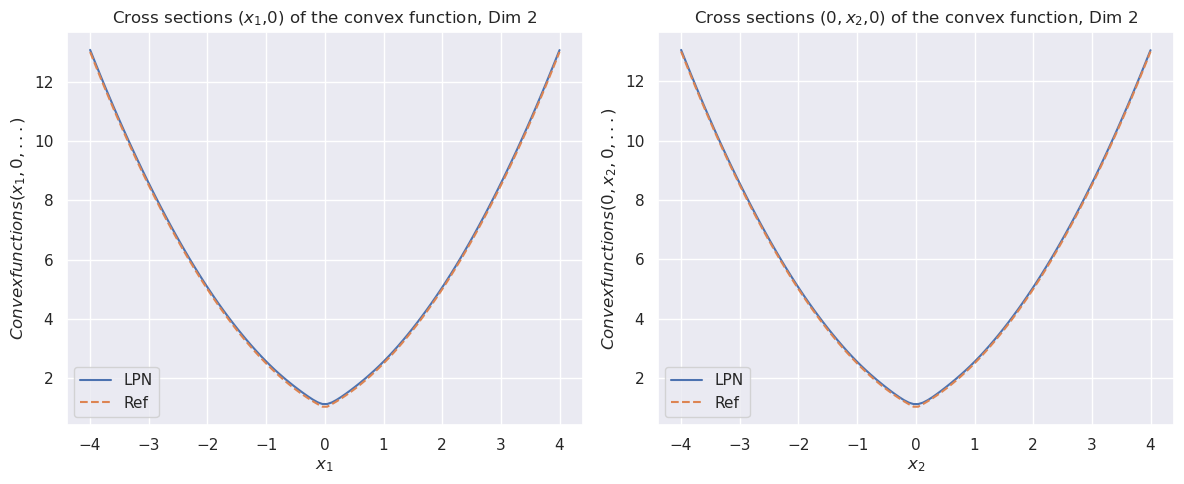

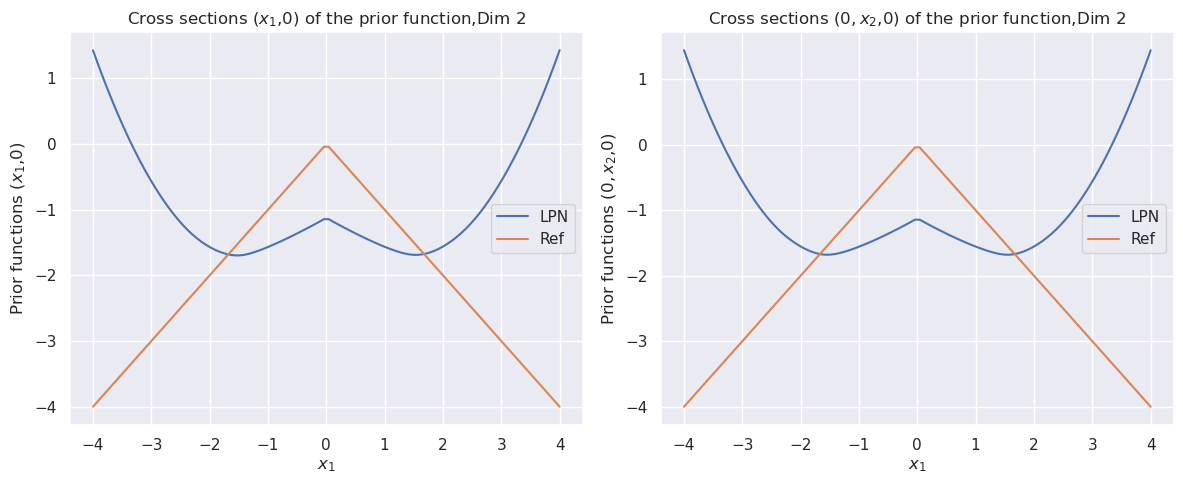

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 32.47908401489258
iteration 0 loss 2214.9755859375


iteration 5000 loss 0.006692869588732719


iteration 10000 loss 0.0010412102565169334


iteration 15000 loss 0.0005454693455249071


iteration 20000 loss 0.00048377952771261334


iteration 25000 loss 0.0002551848301663995


iteration 30000 loss 0.0002207757643191144


iteration 35000 loss 0.00018911644292529672


iteration 40000 loss 0.0001816361618693918


iteration 45000 loss 0.0003253791364841163


iteration 50000 loss 0.00016225942817982286


iteration 55000 loss 0.00011416129564167932


iteration 60000 loss 0.00010295057290932164


iteration 65000 loss 9.278556535718963e-05


iteration 70000 loss 0.0006521348841488361


iteration 75000 loss 8.362578955711797e-05


iteration 80000 loss 7.446302333846688e-05


iteration 85000 loss 6.970280810492113e-05


iteration 90000 loss 7.22016193321906e-05


iteration 95000 loss 6.567203672602773e-05


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 6.148684042273089e-05


iteration 105000 loss 5.053909990238026e-05


iteration 110000 loss 4.311513839638792e-05


iteration 115000 loss 3.86283609259408e-05


iteration 120000 loss 3.5314940760144964e-05


iteration 125000 loss 3.302193363197148e-05


iteration 130000 loss 3.108094824710861e-05


iteration 135000 loss 2.9384502340690233e-05


iteration 140000 loss 2.7896137908101082e-05


iteration 145000 loss 2.6646586775314063e-05


iteration 150000 loss 2.551219949964434e-05


iteration 155000 loss 2.4446559109492227e-05


iteration 160000 loss 2.3605516616953537e-05


iteration 165000 loss 2.2712498321197927e-05


iteration 170000 loss 2.197653338953387e-05


iteration 175000 loss 2.1274523533065803e-05


iteration 180000 loss 2.0668652723543346e-05


iteration 185000 loss 2.2907326638232917e-05


iteration 190000 loss 1.9479131879052147e-05


iteration 195000 loss 1.898761729535181e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 1.8525466657592915e-05


iteration 205000 loss 1.831139888963662e-05


iteration 210000 loss 1.783421430445742e-05


iteration 215000 loss 1.7421862139599398e-05


iteration 220000 loss 1.703519774309825e-05


iteration 225000 loss 1.6660645997035317e-05


iteration 230000 loss 1.631411760172341e-05


iteration 235000 loss 1.5985575373633765e-05


iteration 240000 loss 1.5659006749046966e-05


iteration 245000 loss 1.5352272384916432e-05


iteration 250000 loss 1.5073176655278075e-05


iteration 255000 loss 1.480551600252511e-05


iteration 260000 loss 1.455190431443043e-05


iteration 265000 loss 1.4309246580523904e-05


iteration 270000 loss 1.4072151316213422e-05


iteration 275000 loss 1.3846283763996325e-05


iteration 280000 loss 1.363400588161312e-05


iteration 285000 loss 1.3424077224044595e-05


iteration 290000 loss 1.322349544352619e-05


iteration 295000 loss 1.3034434232395142e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 1.2851251085521653e-05


iteration 305000 loss 1.2773287380696274e-05


iteration 310000 loss 1.2589159268827643e-05


iteration 315000 loss 1.2407124813762493e-05


iteration 320000 loss 1.2240472642588429e-05


iteration 325000 loss 1.2074070582457352e-05


iteration 330000 loss 1.1909564818779472e-05


iteration 335000 loss 1.1764442206185777e-05


iteration 340000 loss 1.1616078154474963e-05


iteration 345000 loss 1.1472749065433163e-05


iteration 350000 loss 1.1332852409395855e-05


iteration 355000 loss 1.1206753697479144e-05


iteration 360000 loss 1.1076728696934879e-05


iteration 365000 loss 1.095055449695792e-05


iteration 370000 loss 1.0828352969838306e-05


iteration 375000 loss 1.0719276360759977e-05


iteration 380000 loss 1.0607248441374395e-05


iteration 385000 loss 1.050243645295268e-05


iteration 390000 loss 1.0400345672678668e-05


iteration 395000 loss 1.0302397640771233e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 1.0206207662122324e-05


iteration 405000 loss 1.0179248420172371e-05


iteration 410000 loss 1.0085556823469233e-05


iteration 415000 loss 9.995099389925599e-06


iteration 420000 loss 9.907258572638966e-06


iteration 425000 loss 9.822795618674718e-06


iteration 430000 loss 9.738298103911802e-06


iteration 435000 loss 9.655302164901514e-06


iteration 440000 loss 9.572294402460102e-06


iteration 445000 loss 9.49156947172014e-06


iteration 450000 loss 9.412156032340135e-06


iteration 455000 loss 9.335479262517765e-06


iteration 460000 loss 9.26145185076166e-06


iteration 465000 loss 9.189501724904403e-06


iteration 470000 loss 9.120085451286286e-06


iteration 475000 loss 9.05286560737295e-06


iteration 480000 loss 8.987758519651834e-06


iteration 485000 loss 8.924385838326998e-06


iteration 490000 loss 8.862342838256154e-06


iteration 495000 loss 8.802590855339076e-06


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


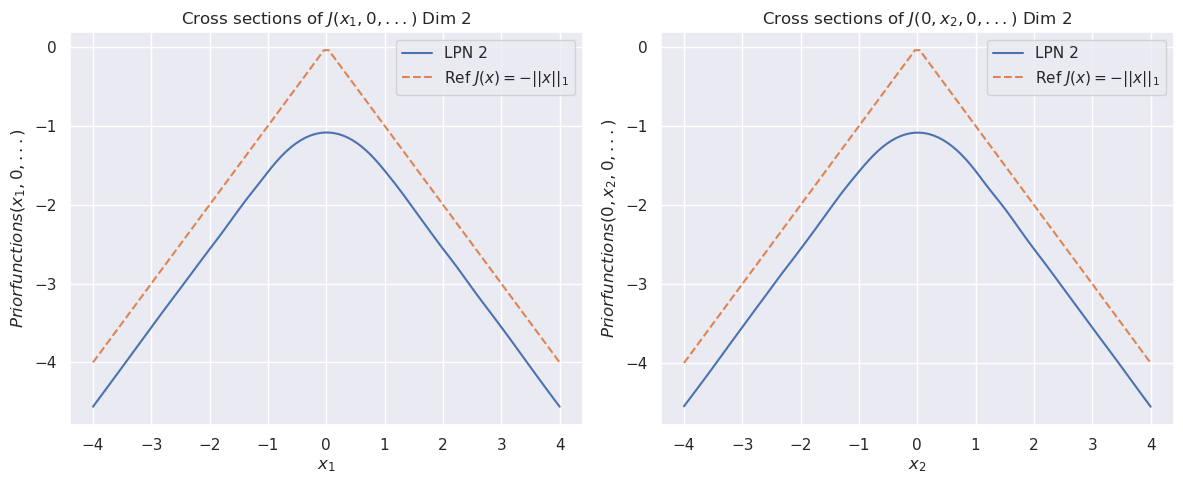

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)